## How to simulate extra-tidal stars and binaries of globular clusters with Corespray.

#### STEP 0: Import the necessary Python packages. 

$\texttt{corespray}$ can be downloaded at: https://github.com/webbjj/corespray. 
$\texttt{galpy}$ (Bovy 2015) can be downloaded at: https://docs.galpy.org/en/v1.8.0/. 
$\texttt{clustertools}$ can be downloaded at: https://clustertools.readthedocs.io/en/latest/.

In [1]:
# Import corespray:
from corespray import corespraydf

# Import galpy packages:
from galpy.potential import MWPotential2014
from galpy.potential import KingPotential
from galpy.util import conversion
from galpy.orbit import Orbit

# Import clustertools:
import clustertools

# Import other necessary Python packages:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from matplotlib import animation

/Users/webbjere/Codes/clustertools/clustertools/analysis/profiles.py:37: FutureWarning: all profiles are setup such that the returned radial bins and profile values are in linear space and not normalized by the effective radius. Previously select profiles had unique returns.
  warnings.warn('all profiles are setup such that the returned radial bins and profile values are in linear space and not normalized by the effective radius. Previously select profiles had unique returns.',FutureWarning)



#### STEP 1: Load in the specific parameters for your GC of interest:
Spatial, kinematic and orbital parameters for most Galactic GCs can be found in the Baumgardt & Hilker (2018) catalogue. This catalogue is accessible at: https://people.smp.uq.edu.au/HolgerBaumgardt/globular/. For this example, we simulate extra-tidal stars and binaries of M3. 

In [2]:
gcname ='M3' # GC name
mu0 = 0.  # Average 1D velocity in the core [km/s]
sig0 = 7.6  # Central 1D velocity dispersion [km/s]
vesc0 = 30.0  # Central escape velocity [km/s]
logrho0 = 3.67  # Log of central density [Msol / pc^3]
rho0 = 10.0**3.67  # Core density [Msol / pc^3]
mgc = 4.06e5  # Mass [solar masses]
rgc = 127.28  # Tidal radius of GC, assuming King potential [pc]
rcore = 1.23  # Core radius of GC [pc]
#W0 = clustertools.c_to_w0(np.log(rgc/rcore))
W0 = 8.61469762517307

mmin = 0.1 # Minimum stellar mass in core [Msol]
mmax = 1.4 # Maximum stellar mass in the core [Msol]
alpha = -1.35 # Stellar mass function in the core slope (Salpeter 1955)

potential = MWPotential2014  # Galactic potential model
ro = 8. #radius of the solar circle (needed for galpy)
vo = 220. #circular orbit velocity at the solar circle (needed for galpy)

#### STEP 2: Initialize the cluster's orbit in galpy:

In [3]:
os_init = Orbit.from_name(gcname, ro=ro, vo=vo, solarmotion=[-11.1, 24.0, 7.25])

#### STEP 3: Integrate the orbit:

In [4]:
ts = np.linspace(0,10,1000)  # integration times
os_init.integrate(ts, potential)  # can choose which Galactic potential to use (e.g. MWPotenial2014)

#### STEP 5: Determine the maximum orbital period of the GC.

In [5]:
# Find the maximum orbital period of the GC:
p_orb_rad = os_init.Tr()
p_orb_phi = os_init.Tp()
p_orb_max = max(np.array([p_orb_rad, p_orb_phi]))
print("The maximum orbital period of M3 is {} Gyr.".format(p_orb_max))

The maximum orbital period of M3 is 0.3863629220270603 Gyr.


### STEP 6: Initialize a corespray instance using your previously defined parameters and integrate orbit for 1 orbital period (duration of orbit integration is of course a free parameter). Then sample core ejections over 1 orbital period

In [6]:
# Initialize corespray
cspray = corespraydf(gcname, potential, mu0, sig0, vesc0, rho0, mgc, rgc, W0, mmin, mmax, alpha)
#Sample for one orbital period
p_orb = p_orb_max * 1000  # Myr 
os,ob = cspray.sample(p_orb, nstar=10, binaries=True)

#### STEP 6: Extract parameters for the SINGLE escapers:

In [7]:
ra = os.ra()  # [deg]
dec = os.dec()  # [deg]
dist = os.dist()  # [kpc]
pmra = os.pmra()  # [mas/yr]
pmdec = os.pmdec() # [mas/yr]
vr = os.vlos()  # [km/s]
r = os.R()  # [kpc]
z = os.z()  # [kpc]
t_esc = cspray.tesc  # [Myr] in the past
v_esc = cspray.vesc  # [km/s]
mstar = cspray.mstar # [Msol]

#### STEP 6: Extract parameters for all BINARY stars:

In [8]:
ra_b = ob.ra()  # [deg]
dec_b = ob.dec()  # [deg]
dist_b = ob.dist()  # [kpc]
pmra_b = ob.pmra()  # [mas/yr]
pmdec_b = ob.pmdec()  # [mas/yr]
vr_b = ob.vlos()  # [km/s]
r_b = ob.R()  # [kpc]
z_b = ob.z()  # [kpc]
# Would tesc of binary be same as escaper star?
v_esc_b = cspray.vescb  # [km/s]
m_b1 = cspray.mb1  # [Msol]
m_b2 = cspray.mb2  # [Msol]
m_b_tot = m_b1 + m_b2  # [Msol]

# bindx is a boolean that gives indxs of binaries that escaped the cluster: 
bin_esc = cspray.bindx
print("{}/{} binaries escaped {}.".format(len(ra_b[bin_esc]), len(ra_b), gcname))

0/10 binaries escaped M3.


#### Explore some parameter spaces of your simulated extra-tidal stars and binaries!

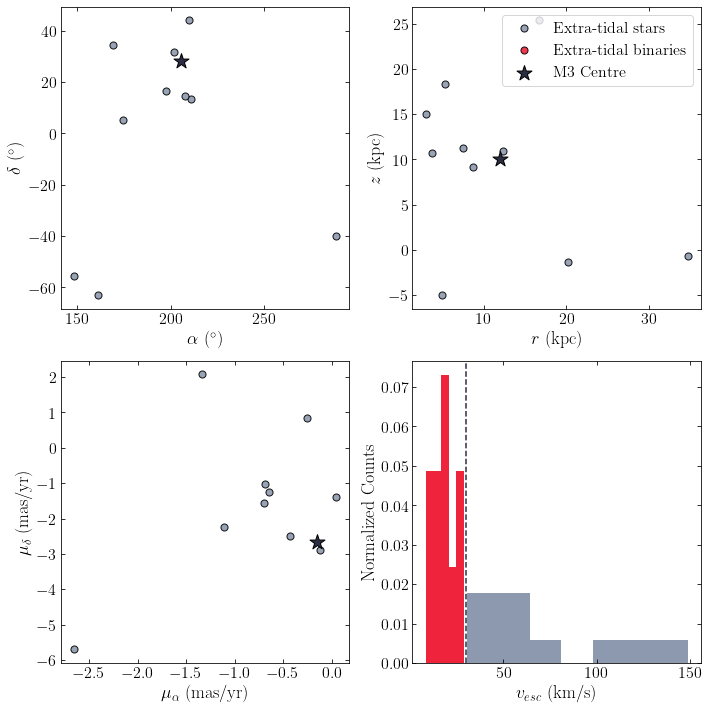

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# RA vs Dec positions:
ax[0, 0].scatter(ra, dec, marker='o', s=50, edgecolor='black', c='#8d99ae', alpha=0.9) 
ax[0, 0].scatter(ra_b[bin_esc], dec_b[bin_esc], marker='o', s=50, edgecolor='black', c='#ef233c', alpha=0.9) 
ax[0, 0].scatter(cspray.o.ra(), cspray.o.dec(), marker='*', s=250, edgecolor='black', c='#2b2d42')
ax[0, 0].set_xlabel(r"$\alpha$ ($^\circ $)", fontsize=18)
ax[0, 0].set_ylabel(r"$\delta$ ($^\circ $)", fontsize=18)
ax[0, 0].tick_params(axis='both', which='major', labelsize=16)
ax[0, 0].tick_params(axis='both', which='minor', labelsize=16)

# R vs z positions:
ax[0, 1].scatter(r, z, marker='o', s=50, edgecolor='black', c='#8d99ae', alpha=0.9, label='Extra-tidal stars') 
ax[0, 1].scatter(r_b[bin_esc], z_b[bin_esc], marker='o', s=50, edgecolor='black', c='#ef233c', alpha=0.9, label='Extra-tidal binaries') 
ax[0, 1].scatter(cspray.o.r(), cspray.o.z(), marker='*', s=250, edgecolor='black', c='#2b2d42', label='M3 Centre')
ax[0, 1].set_xlabel(r"$r$ (kpc)", fontsize=18)
ax[0, 1].set_ylabel(r"$z$ (kpc)", fontsize=18)
ax[0, 1].tick_params(axis='both', which='major', labelsize=16)
ax[0, 1].tick_params(axis='both', which='minor', labelsize=16)
ax[0, 1].legend(fontsize=16)

# Proper motion:
ax[1, 0].scatter(pmra, pmdec, marker='o', s=50, edgecolor='black', c='#8d99ae', alpha=0.9) 
ax[1, 0].scatter(pmra_b[bin_esc], pmdec_b[bin_esc], marker='o', s=50, edgecolor='black', c='#ef233c', alpha=0.9) 
ax[1, 0].scatter(cspray.o.pmra(), cspray.o.pmdec(), marker='*', s=250, edgecolor='black', c='#2b2d42')
ax[1, 0].set_xlabel(r"$\mu_{\alpha}$ (mas/yr)", fontsize=18)
ax[1, 0].set_ylabel(r"$\mu_{\delta}$ (mas/yr)", fontsize=18)
ax[1, 0].tick_params(axis='both', which='major', labelsize=16)
ax[1, 0].tick_params(axis='both', which='minor', labelsize=16)

# Escape velocities:
ax[1, 1].hist(v_esc, bins=7, color='#8d99ae', density=True)
ax[1, 1].hist(v_esc_b, bins=5, color='#ef233c', density=True)
ax[1, 1].axvline(vesc0, ls='--', c='#2b2d42')
ax[1, 1].tick_params(axis='both', which='major', labelsize=16)
ax[1, 1].tick_params(axis='both', which='minor', labelsize=16)
ax[1, 1].set_xlabel(r"$v_{esc}$ (km/s)", fontsize=18)
ax[1, 1].set_ylabel("Normalized Counts", fontsize=18)

fig.tight_layout()
plt.show()